# シンプルなFC層を用いたモデル

### 方針

・条件付き確率（遷移確率）と尤度の和から次の尤度を求める

### データの生成

・データの用意

In [28]:
import numpy as np

# 依存関係の行列 A (問題の依存関係)
A = np.array([
    [0, 0, 0, 0, 0],  # 問題1は他の問題に依存しない
    [1, 0, 0, 0, 0],  # 問題2は問題1に依存
    [1, 1, 0, 0, 0],  # 問題3は問題1と問題2に依存
    [0, 1, 0, 0, 0],  # 問題4は問題2に依存
    [1, 1, 1, 0, 0]   # 問題5は問題1、問題2、問題3に依存
])


# 次に正解する確率を求める関数
def calculate_transition_probabilities(A, X):
    n = len(X)
    raw_probabilities = np.zeros(n)  # 遷移確率の元となる値
    
    # 不正解の問題に対して遷移確率を計算
    for i in range(n):
        if X[i] == 0:  # 不正解の問題のみ計算
            required_problems = A[i, :]  # i番目の問題に必要な依存関係
            
            # 依存関係がすべて0であるかを確認
            if np.all(required_problems == 0):
                raw_probabilities[i] =  10 # 必要なら、この問題の遷移確率を設定
                continue
            
            solved_problems = X * required_problems  # 実際に解けた問題
            
            num_required = np.sum(required_problems)  # 必要な問題の数
            num_solved = np.sum(solved_problems)      # 実際に解けた問題の数
            
            if num_required > 0:
                raw_probabilities[i] = np.exp(num_solved / num_required)
    
    # 総和で割って正規化
    total_sum = np.sum(raw_probabilities)  # expの総和
    if total_sum > 0:  # 総和が0でなければ正規化
        probabilities = raw_probabilities / total_sum
    else:
        probabilities = raw_probabilities  # 総和が0ならそのまま
    
    return probabilities

In [29]:
# 生徒の回答状況 X (1が正解、0が不正解)
# 例: 問題1と問題2は正解、問題3と問題4と問題5は不正解
X = np.array([1, 1, 0, 0, 0])

# 遷移確率の計算
probabilities = calculate_transition_probabilities(A, X)

# 結果を表示
print("次に正解する確率:")
for i, prob in enumerate(probabilities):
    print(f"問題{i+1}: {prob:.4f}")

次に正解する確率:
問題1: 0.0000
問題2: 0.0000
問題3: 0.3681
問題4: 0.3681
問題5: 0.2638


In [30]:
# データセットを生成する関数
def generate_dataset(A, initial_X, num_correct_problems, num_data_per_step):
    n = len(initial_X)  # 問題数（今回は5）
    dataset = []
    
    # 正解させたい問題数ごとにデータを生成
    for i in range(num_correct_problems + 1):  # 0から正解問題数 i
        for j in range(num_data_per_step):  # 各ステップごとにデータ数
            X = initial_X.copy()  # 初期状態からスタート
            for k in range(i):  # i問正解させる
                probabilities = calculate_transition_probabilities(A, X)
                
                if np.sum(probabilities) > 0:  # 正規化された確率がある場合
                    # 確率に基づいて次に正解させる問題を選択
                    next_correct_problem = np.random.choice(n, p=probabilities)
                    X[next_correct_problem] = 1  # 選ばれた問題を正解に遷移させる
            
            dataset.append(X.copy())  # データセットに追加
    
    return np.array(dataset)

In [31]:
# データセット生成
num_correct_problems = 5  # 0問から5問まで正解
num_data_per_step = 100     # 各ステップごとに生成するデータ数

# 生徒の回答状況 X (1が正解、0が不正解)
# 初期状態は全て不正解
X_init = np.array([0, 0, 0, 0, 0])

dataset = generate_dataset(A, X_init, num_correct_problems, num_data_per_step)

# 結果を表示
print("生成されたデータセット:")
print(dataset)

生成されたデータセット:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 ...
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


In [32]:
# import numpy as np

# # 生徒数と問題数を設定
# num_students = 100  # 生徒の数
# num_questions = 5   # 問題の数

# # ランダムに正解(1)または不正解(0)を生成
# np.random.seed(42)  # 再現性のためのシード値設定
# test_results = np.random.randint(0, 2, size=(num_students, num_questions)).tolist()

# # 追加するデータセット
# additional_data = [
#     [1, 0, 0, 0, 0],
#     [1, 1, 0, 0, 0],
#     [1, 1, 1, 0, 0],
#     [1, 1, 1, 1, 0],
#     [1, 1, 1, 1, 1]
# ]

# # 各データを3つずつ追加
# for data in additional_data:
#     test_results.extend([data] * 5)  # 同じデータを5回追加

# # 結果を表示
# for i, result in enumerate(test_results):
#     print(f"Student {i+1}: {result}")

# print(type(additional_data))

In [33]:
import itertools
from collections import defaultdict

num_questions = 5

# 問題数5問に対する全ての可能な状態 (2^5 = 32状態)
states = list(itertools.product([0, 1], repeat=num_questions))
print(f"Number of States: {len(states)}\n")

# 各状態（ノード）に生徒を配置する (状態ごとの生徒数をカウント)
state_counts = defaultdict(int)

# 生徒ごとのテスト結果を元に状態に生徒をカウント
for result in dataset:
    state_tuple = tuple(map(int, result))  # np.int64をint型に変換
    state_counts[state_tuple] += 1

# 各状態の生徒数を表示
for state, count in state_counts.items():
    formatted_state = ''.join(map(str, state))  # 状態を'01010'のような形式に変換
    print(f"State [{formatted_state}]: {count} students")


Number of States: 32

State [00000]: 100 students
State [10000]: 78 students
State [00010]: 9 students
State [01000]: 5 students
State [00100]: 7 students
State [00001]: 1 students
State [11000]: 34 students
State [10010]: 18 students
State [10100]: 23 students
State [00110]: 2 students
State [10001]: 20 students
State [01001]: 1 students
State [01100]: 1 students
State [00101]: 1 students
State [11001]: 17 students
State [11100]: 29 students
State [10110]: 9 students
State [11010]: 24 students
State [10101]: 10 students
State [10011]: 9 students
State [01011]: 1 students
State [01110]: 1 students
State [10111]: 9 students
State [11110]: 32 students
State [11101]: 34 students
State [11011]: 25 students
State [11111]: 100 students


・遷移確率の計算

In [34]:
# 遷移確率を計算するための準備
transition_probabilities = defaultdict(dict)

# 各状態について、次の状態に遷移する確率を計算
for current_state, count in state_counts.items():
    # 次に解ける可能性のある未解決の問題を見つける
    for i in range(num_questions):
        if current_state[i] == 0:  # まだ解けていない問題
            # その問題が解けた状態を生成（遷移後の状態）
            next_state = list(current_state)
            next_state[i] = 1
            next_state = tuple(next_state)
            
            # 現在の状態から次の状態に遷移する確率を仮定 (生徒が1問解ける)
            transition_probabilities[current_state][next_state] = 1 / (num_questions - sum(current_state))

# 遷移確率の表示
for current_state, next_states in transition_probabilities.items():
    print(f"From state {current_state}:")
    for next_state, prob in next_states.items():
        print(f"  To {next_state} with probability {prob:.2f}")

From state (0, 0, 0, 0, 0):
  To (1, 0, 0, 0, 0) with probability 0.20
  To (0, 1, 0, 0, 0) with probability 0.20
  To (0, 0, 1, 0, 0) with probability 0.20
  To (0, 0, 0, 1, 0) with probability 0.20
  To (0, 0, 0, 0, 1) with probability 0.20
From state (1, 0, 0, 0, 0):
  To (1, 1, 0, 0, 0) with probability 0.25
  To (1, 0, 1, 0, 0) with probability 0.25
  To (1, 0, 0, 1, 0) with probability 0.25
  To (1, 0, 0, 0, 1) with probability 0.25
From state (0, 0, 0, 1, 0):
  To (1, 0, 0, 1, 0) with probability 0.25
  To (0, 1, 0, 1, 0) with probability 0.25
  To (0, 0, 1, 1, 0) with probability 0.25
  To (0, 0, 0, 1, 1) with probability 0.25
From state (0, 1, 0, 0, 0):
  To (1, 1, 0, 0, 0) with probability 0.25
  To (0, 1, 1, 0, 0) with probability 0.25
  To (0, 1, 0, 1, 0) with probability 0.25
  To (0, 1, 0, 0, 1) with probability 0.25
From state (0, 0, 1, 0, 0):
  To (1, 0, 1, 0, 0) with probability 0.25
  To (0, 1, 1, 0, 0) with probability 0.25
  To (0, 0, 1, 1, 0) with probability 0.25


### 尤度（ベイズ）

In [35]:
# ベイズの定理に基づく遷移確率の計算
bayesian_transition_probabilities = defaultdict(dict)

for current_state, next_states in transition_probabilities.items():
    P_S = state_counts[current_state] / sum(state_counts.values())  # 状態Sにいる確率
    for next_state, P_S_given_S_prime in next_states.items():
        # ベイズの定理に基づく遷移確率 P(S'|S)
        bayesian_transition_probabilities[current_state][next_state] = P_S_given_S_prime * P_S

# ベイズ遷移確率を表示
for current_state, next_states in bayesian_transition_probabilities.items():
    print(f"From state {current_state}:")
    for next_state, prob in next_states.items():
        print(f"  To {next_state} with bayesian probability {prob:.2f}")


From state (0, 0, 0, 0, 0):
  To (1, 0, 0, 0, 0) with bayesian probability 0.03
  To (0, 1, 0, 0, 0) with bayesian probability 0.03
  To (0, 0, 1, 0, 0) with bayesian probability 0.03
  To (0, 0, 0, 1, 0) with bayesian probability 0.03
  To (0, 0, 0, 0, 1) with bayesian probability 0.03
From state (1, 0, 0, 0, 0):
  To (1, 1, 0, 0, 0) with bayesian probability 0.03
  To (1, 0, 1, 0, 0) with bayesian probability 0.03
  To (1, 0, 0, 1, 0) with bayesian probability 0.03
  To (1, 0, 0, 0, 1) with bayesian probability 0.03
From state (0, 0, 0, 1, 0):
  To (1, 0, 0, 1, 0) with bayesian probability 0.00
  To (0, 1, 0, 1, 0) with bayesian probability 0.00
  To (0, 0, 1, 1, 0) with bayesian probability 0.00
  To (0, 0, 0, 1, 1) with bayesian probability 0.00
From state (0, 1, 0, 0, 0):
  To (1, 1, 0, 0, 0) with bayesian probability 0.00
  To (0, 1, 1, 0, 0) with bayesian probability 0.00
  To (0, 1, 0, 1, 0) with bayesian probability 0.00
  To (0, 1, 0, 0, 1) with bayesian probability 0.00
From

・図示

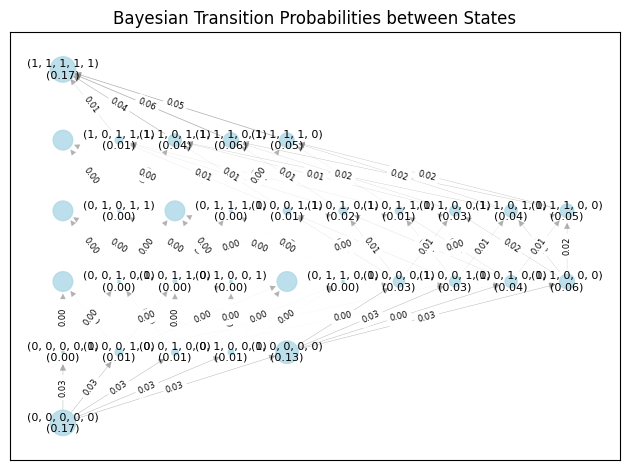

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

# 問題数
num_questions = 5

# 全ての状態(2^5 = 32通り)を生成
states = list(itertools.product([0, 1], repeat=num_questions))

# グラフの作成
G = nx.DiGraph()

# ノードを追加（状態をノードとして）
state_likelihoods = {}
for state, count in state_counts.items():
    likelihood = count / sum(state_counts.values())  # 尤度の計算
    state_likelihoods[state] = likelihood
    G.add_node(state, label=f"{state}\n({likelihood:.2f})")  # ノードの追加

# エッジを追加（遷移確率をエッジとして）
for current_state, next_states in bayesian_transition_probabilities.items():
    for next_state, prob in next_states.items():
        G.add_edge(current_state, next_state, weight=prob)

# ノードの階層に基づくレイアウトを定義
def generate_hierarchy_pos(states):
    layers = defaultdict(list)  # 各ビット数ごとに層を分ける
    for state in states:
        bit_count = sum(state)  # 1の数に応じて層を決定
        layers[bit_count].append(state)

    pos = {}
    y_step = 1.0  # 各層ごとの縦の間隔 (正の値にして上下を逆に)
    x_step = 1 / max(len(layer) for layer in layers.values())  # 横の間隔は最大層のノード数で決める
    for bit_count, layer in sorted(layers.items()):
        y = bit_count * y_step
        x_positions = [i * x_step for i in range(len(layer))]
        for x, state in zip(x_positions, layer):
            pos[state] = (x, y)
    return pos

# ノードの位置を階層構造に基づいて設定
pos = generate_hierarchy_pos(states)

# ノードのサイズを尤度に基づいて設定
sizes = [state_likelihoods.get(state, 0.1) * 2000 for state in G.nodes]  # ノードサイズはリストとして渡す

# ノードの描画
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='lightblue', alpha=0.8)

# エッジの描画（遷移確率に基づいてエッジの太さを調整）
edges = G.edges(data=True)
weights = [d['weight'] * 10 for (u, v, d) in edges]  # 遷移確率に基づいてエッジの太さを設定
nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', alpha=0.6)

# ノードのラベルを描画（フォントサイズを調整）
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, verticalalignment='center', horizontalalignment='center')

# エッジのラベル（遷移確率）を表示（フォントサイズを小さくし、読みやすく配置）
edge_labels = {(u, v): f"{d['weight']:.2f}" for (u, v, d) in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

# グラフを表示
plt.title("Bayesian Transition Probabilities between States", fontsize=12)
plt.tight_layout()
plt.show()


### 学習

### テスト